In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy.stats import linregress
import statsmodels.api as sm


------

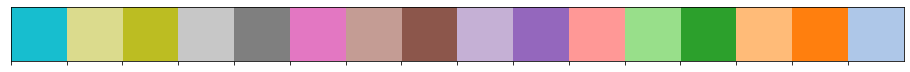

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)

----

# Excercise 2: Moneyball

Moneyball, as well as being a fantastic story, is also a true story of statistical methods being applied in a real world context to make predictions for decision making. [The film Moneyball](https://www.youtube.com/watch?v=-4QPVo0UIzc) is well worth a watch if you have time. As well as in baseball most major competitive sports teams are now using data science to improve their performance, e.g. [football](http://outsideoftheboot.com/2013/06/26/rise-of-data-analysis-in-football/),...

In this excercise you have been hired by Oakland Athletics general manager Billy Beane. Your first mission is to predict the salary each player will make based on other information that is available. This will allow Billy to understand what price he should pay for players in the next transfer season.

You must:
* Import and prepare the data
* Create a train and test set
* Implement a regularised model of your choice (Ridge or Lasso)
* Choose optimal parameters for your regularised model
* Estimate test-error using k-fold cross validation
* Calculate the true test-error
* Run a base line model to compare your model results. Base line model is the most simple approach based on strategy of choice (mean or other). It is then used as reference to conclude whether more complex models are better or not: see DummyRegressor in the sklearn library.

HINT 1
* Some values are missing. You can drop these rows.

HINT 2
* Some columns do not contain numerical values. You can drop these columns. In the Machine Learning model you'll learn more about labeling categorical data

In [3]:
def  compute_indicator(true_values,predicted_values):
    MSE = mean_squared_error(true_values, predicted_values)
    MAE = mean_absolute_error(true_values, predicted_values)
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MEDAE = median_absolute_error(true_values, predicted_values)
    R2 = r2_score(true_values, predicted_values)
    print(f"MSE ----> {MSE}")
    print(f"RMSE ---> {RMSE}")
    print(f"MAE ----> {MAE}")
    print(f"MEDAE --> {MEDAE}")
    print(f"R2 -----> {R2}")
    return MSE, RMSE, MAE, MEDAE, R2

In [4]:
def print_shape(df):
    print(f"Samples ---> {df.shape[0]}")
    print(f"Features --> {df.shape[1]}")

In [5]:
def plot_result_alpha(results, name):
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(18,9))
    fig.suptitle("Alpha study for" + name, fontsize=20)
    
    sns.lineplot(
        ax=ax[0],
        x=results["param_alpha"], 
        y=-results["mean_test_score"], 
        data=results,
        color=colors[0],
    )
    
    ax[0].set_ylabel("MSE | STD", fontsize=15)
    ax[0].set_title(f"MSE", fontsize=20)
    
    sns.lineplot(
        ax=ax[1],
        x=results["param_alpha"], 
        y=results["std_test_score"], 
        data=results,
        color=colors[0],
    )
    ax[0].set_xlabel(" ", fontsize=15)
    ax[1].set_xlabel("Alpha", fontsize=15)
    ax[1].set_ylabel("STD", fontsize=15)
    
    fig.subplots_adjust(wspace=10)
    plt.show()

# Import and Prepare

In [6]:
df_hitters = pd.read_csv('./data/hitters.csv')
df_hitters = df_hitters.rename(columns={'Unnamed: 0': 'name'})

In [7]:
print_shape(df_hitters)

Samples ---> 322
Features --> 21


In [8]:
df_hitters.dtypes

name          object
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [9]:
df_hitters = df_hitters.drop(df_hitters.select_dtypes(include=['object']).columns, axis=1)
print_shape(df_hitters)

Samples ---> 322
Features --> 17


In [10]:
df_hitters = df_hitters.dropna()
print_shape(df_hitters)
print("---------------------")
print("On perd 59 samples")

Samples ---> 263
Features --> 17
---------------------
On perd 59 samples


In [11]:
salary = df_hitters.pop("Salary")
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25


<AxesSubplot:>

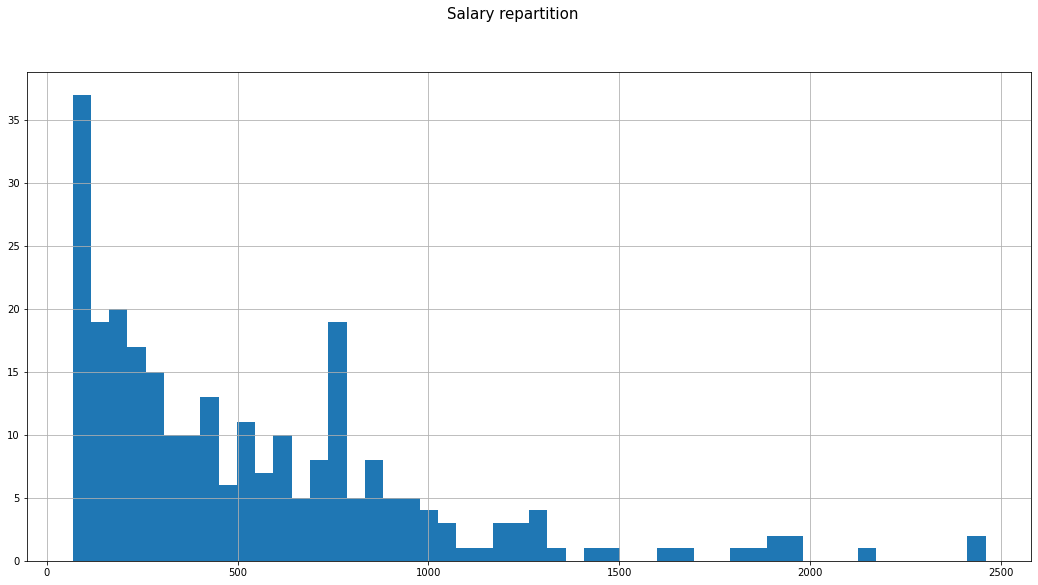

In [12]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Salary repartition", fontsize=15)
salary.hist(bins=50)

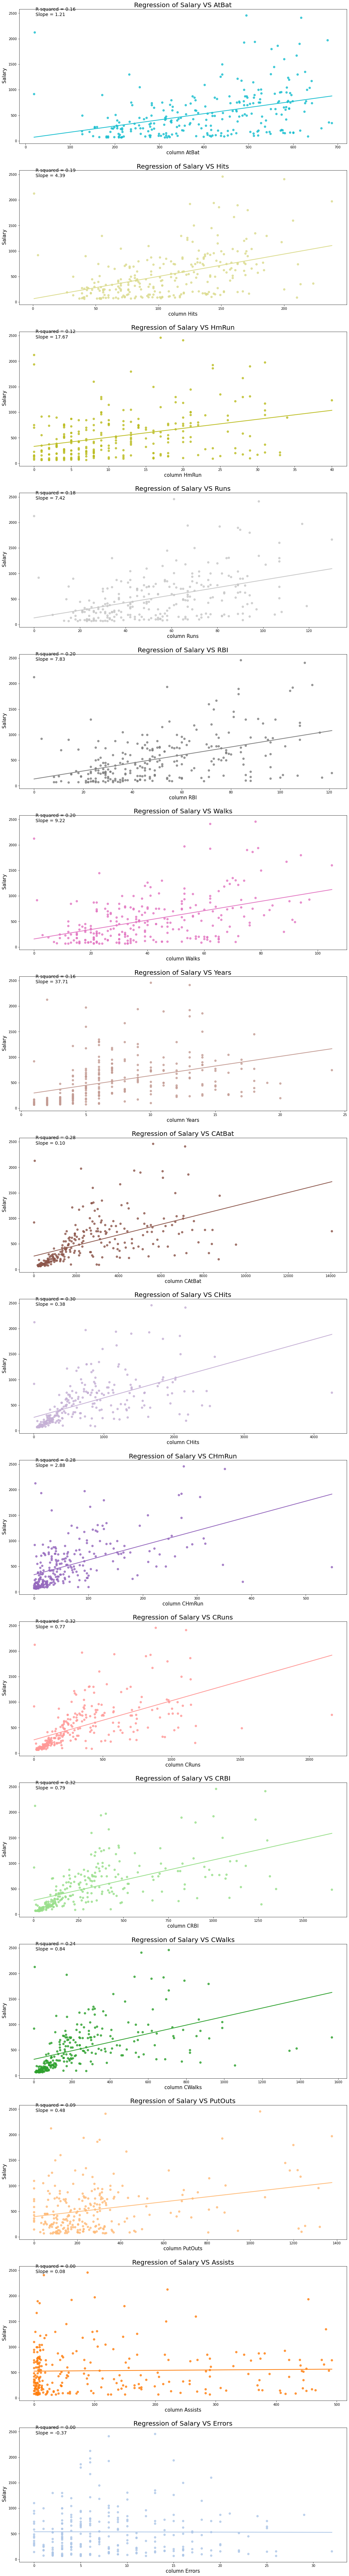

In [13]:
fig, ax = plt.subplots(nrows=len(df_hitters.columns), ncols=1, figsize=(18,9*len(df_hitters.columns)))

for i, col in enumerate(df_hitters.columns):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_hitters[col], salary)
    r_squared = r_value ** 2
    
    sns.regplot(
        ax=ax[i],
        x=col, 
        y=salary, 
        data=df_hitters,
        color=colors[i],
        ci=None
    )
    ax[i].set_xlabel(f"column {col}", fontsize=15)
    ax[i].set_ylabel(f" Salary", fontsize=15)
    ax[i].set_title(f"Regression of Salary VS {col}", fontsize=20)
    ax[i].annotate("R-squared = {:.2f}\nSlope = {:.2f}".format(r_squared, slope),
            xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14)

plt.show()

<AxesSubplot:>

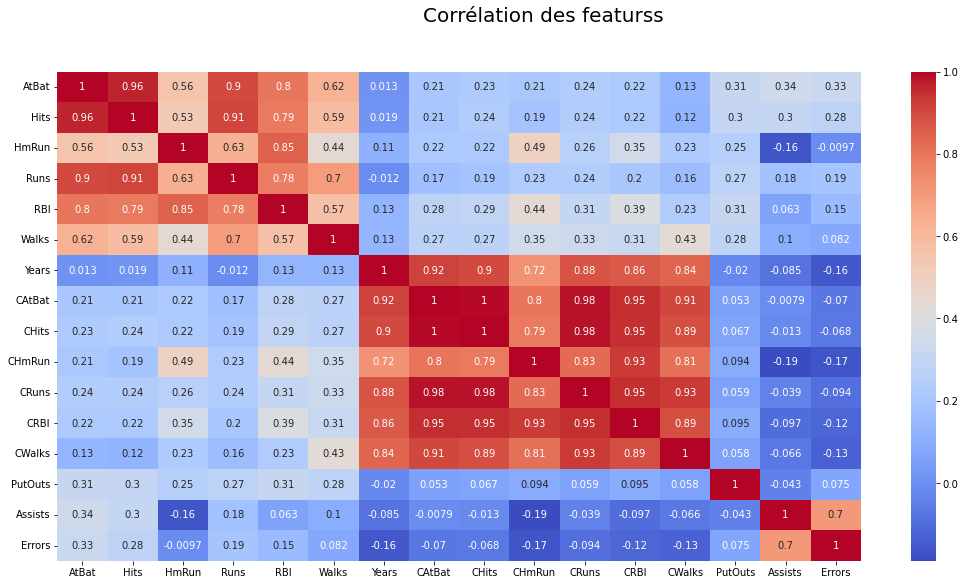

In [14]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Corrélation des featurss", fontsize=20)
sns.heatmap(df_hitters.corr(), cmap="coolwarm", annot=True, annot_kws={"size": 10})

------

In [15]:
print(f"Ecart type de nos données --> {salary.std()}")
print(f"Moyenne de nos données -----> {salary.mean()}")

Ecart type de nos données --> 451.1186807025387
Moyenne de nos données -----> 535.9258821292775


### Prépare test set

In [16]:
def compare_train_test(y_train, y_pred_train, y_test, y_pred_test):
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
    print("Results for TRAIN data :")
    print("")
    compute_indicator(y_train, y_pred_train)
    print("----------------------------------------------")
    print("Results for TEST data ")
    print("")
    compute_indicator(y_test, y_pred_test)
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")

In [17]:
def  compute_indicator(true_values,predicted_values):
    MSE = mean_squared_error(true_values, predicted_values)
    MAE = mean_absolute_error(true_values, predicted_values)
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MEDAE = median_absolute_error(true_values, predicted_values)
    R2 = r2_score(true_values, predicted_values)
    print(f"MSE ----> {MSE}")
    print(f"RMSE ---> {RMSE}")
    print(f"MAE ----> {MAE}")
    print(f"MEDAE --> {MEDAE}")
    print(f"R2 -----> {R2}")
    return MSE, RMSE, MAE, MEDAE, R2

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_hitters, salary, random_state = 18)

# Lasso VS Ridge VS Linear

In [19]:
def kfold_study(model, X, y, rangeValue):
    cv_list = []
    MSE_list = []
    RMSE_list = []
    for i in range(rangeValue[0], rangeValue[1], rangeValue[2]):
        print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
        print(f"CV ---> {i}")
        crossPrediction = cross_val_predict(model, X, y, cv=i)
        MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y, crossPrediction)
        cv_list.append(i)
        MSE_list.append(MSE)
        RMSE_list.append(RMSE)
        
    return cv_list, MSE_list, RMSE_list

### Linear regression

In [20]:
model_linear = LinearRegression()

model_linear.fit(X_train, y_train)

# predict y values for testing data set
y_pred_train = model_linear.predict(X_train)
y_pred_test = model_linear.predict(X_test)

print("------------------------------------------------------")
print("-------------------- LINEAR MODEL --------------------")
print("------------------------------------------------------")
print("")
MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y_test, y_pred_test)
compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

------------------------------------------------------
-------------------- LINEAR MODEL --------------------
------------------------------------------------------

MSE ----> 93902.38051881903
RMSE ---> 306.43495316105674
MAE ----> 240.1304233146088
MEDAE --> 195.92550347718333
R2 -----> 0.4443893225498512
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Results for TRAIN data :

MSE ----> 100601.19453572626
RMSE ---> 317.1769136234954
MAE ----> 215.6727881943707
MEDAE --> 154.57242904158113
R2 -----> 0.5273849576945201
----------------------------------------------
Results for TEST data 

MSE ----> 93902.38051881903
RMSE ---> 306.43495316105674
MAE ----> 240.1304233146088
MEDAE --> 195.92550347718333
R2 -----> 0.4443893225498512
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


In [21]:
cv_scores = cross_val_score(model_linear, X_train, y_train, cv = 10, scoring='neg_mean_squared_error') 
MSE = -cv_scores
RMSE = np.sqrt(MSE)
print("------------------------------------------------------")
print("----------- LINEAR MODEL KFOLD Dispersion ------------")
print("------------------------------------------------------")
print("")
print(f"RMSE --------------------------> {RMSE.mean()}")
print(f"STD des RMSE selon interval ---> {RMSE.std()}")

------------------------------------------------------
----------- LINEAR MODEL KFOLD Dispersion ------------
------------------------------------------------------

RMSE --------------------------> 348.9184404965113
STD des RMSE selon interval ---> 108.24828050177739


## Test Lasso on different kfold

In [23]:
lasso = Lasso()

In [24]:
cv_list, MSE_list, RMSE_list = kfold_study(lasso, X_train, y_train, [2, 40, 2])

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 2
MSE ----> 160902.04222507146
RMSE ---> 401.1259680263439
MAE ----> 262.67839873243383
MEDAE --> 183.3802809689331
R2 -----> 0.24409719144801312
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 4
MSE ----> 150299.58742019598
RMSE ---> 387.68490739284135
MAE ----> 261.310442799896
MEDAE --> 187.84678911569142
R2 -----> 0.29390653664787225
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 6
MSE ----> 137381.69770492197
RMSE ---> 370.65037124616777
MAE ----> 249.27164079160235
MEDAE --> 179.52187063513975
R2 -----> 0.35459357940573566
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 8
MSE ----> 136053.9230846391
RMSE ---> 368.85488079275717
MAE ----> 248.03889719259791
MEDAE --> 174.26881137107193
R2 -----> 0.3608313409078049
°°°°°°°°°°°°°°°°°°

/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3656764.996141866, tolerance: 1869.7373177507561
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4813385.603587628, tolerance: 2323.4113199596627
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6766552.474264903, tolerance: 2921.590670460361
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.

/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8973366.45668764, tolerance: 4060.1750509415083
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9310117.69049574, tolerance: 4052.4290878794345
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7097435.090706761, tolerance: 3528.5766068434477
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9

MSE ----> 129999.42402957682
RMSE ---> 360.5543288182473
MAE ----> 241.69477395118844
MEDAE --> 166.66810036126958
R2 -----> 0.3892748135748274
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 16
MSE ----> 131225.58512304106
RMSE ---> 362.25072135613624
MAE ----> 242.86789695695938
MEDAE --> 173.5497744569891
R2 -----> 0.3835144229578439
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 18
MSE ----> 131850.2754651043
RMSE ---> 363.1119324190604
MAE ----> 244.26006141366975
MEDAE --> 171.66055810681138
R2 -----> 0.38057968591217994
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 20


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8806236.223994287, tolerance: 3732.796860941163
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8977286.097189138, tolerance: 4108.706870823872
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9440458.966895148, tolerance: 4091.6536604919643
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9

MSE ----> 133076.16642841444
RMSE ---> 364.79606142119246
MAE ----> 242.91045834147306
MEDAE --> 176.81145361781785
R2 -----> 0.37482056434150146
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 22
MSE ----> 132504.37717828105
RMSE ---> 364.01150693114226
MAE ----> 243.51523652236273
MEDAE --> 172.46602771280902
R2 -----> 0.377506776984291
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 24
MSE ----> 131088.30846005373
RMSE ---> 362.06119435815503
MAE ----> 242.9471744374557
MEDAE --> 173.57328476188331
R2 -----> 0.38415933593511753
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 26


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9694166.797006544, tolerance: 4065.2895064690956
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9424068.718515024, tolerance: 4135.470244659198
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9563858.559288213, tolerance: 4125.485519365922
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9

MSE ----> 131067.40962753343
RMSE ---> 362.0323322957957
MAE ----> 241.33229917207777
MEDAE --> 168.26519347400733
R2 -----> 0.38425751670385777
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 28
MSE ----> 128806.09642296526
RMSE ---> 358.89566230725785
MAE ----> 239.51125514308708
MEDAE --> 165.1084968499472
R2 -----> 0.3948809555285666
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 30


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9338821.72280712, tolerance: 3883.0555814794975
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7603993.402841166, tolerance: 3841.1891232722655
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9772149.868327787, tolerance: 3974.559287139422
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9

MSE ----> 131376.67339821075
RMSE ---> 362.4592023914012
MAE ----> 241.23321287115346
MEDAE --> 168.70396603435762
R2 -----> 0.3828046243129001
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 32
MSE ----> 131614.20999980898
RMSE ---> 362.78672798189433
MAE ----> 242.01623473967842
MEDAE --> 168.4756760264512
R2 -----> 0.38168869948187245
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 34


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9794657.706990708, tolerance: 4152.072023559331
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9681824.23250726, tolerance: 4100.692416005347
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9690461.750270687, tolerance: 4157.972538577597
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/s

/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9622756.159043478, tolerance: 4141.5677617084875
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9572694.987910416, tolerance: 4131.811773386498
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9794095.412968913, tolerance: 4138.717677018958
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9

MSE ----> 132600.61340449154
RMSE ---> 364.143671377784
MAE ----> 242.92166062582407
MEDAE --> 176.922818125905
R2 -----> 0.37705466815664057
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 36
MSE ----> 132307.02197067736
RMSE ---> 363.7403221677209
MAE ----> 242.61057488189388
MEDAE --> 168.98224599837022
R2 -----> 0.3784339333686787
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 38
MSE ----> 131864.85942753585
RMSE ---> 363.13201377396604
MAE ----> 242.13305833781538
MEDAE --> 168.98224599837022
R2 -----> 0.38051117181497274


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9402196.332141014, tolerance: 3774.473235473677
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9651132.377179826, tolerance: 4155.810731103775
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9288172.362525504, tolerance: 3987.875008425764
  model = cd_fast.enet_coordinate_descent(
/Users/manulabricole/opt/anaconda3/lib/python3.9/

In [25]:
print("------------------------------------------------------")
print("------------ LASSO MODEL KFOLD Dispersion ------------")
print("------------------------------------------------------")
print("")
print(f"RMSE --------------------------> {np.mean(RMSE_list)}")
print(f"STD des RMSE selon interval ---> {np.std(RMSE_list)}")

------------------------------------------------------
------------ LASSO MODEL KFOLD Dispersion ------------
------------------------------------------------------

RMSE --------------------------> 367.0278401280419
STD des RMSE selon interval ---> 9.987948188334018


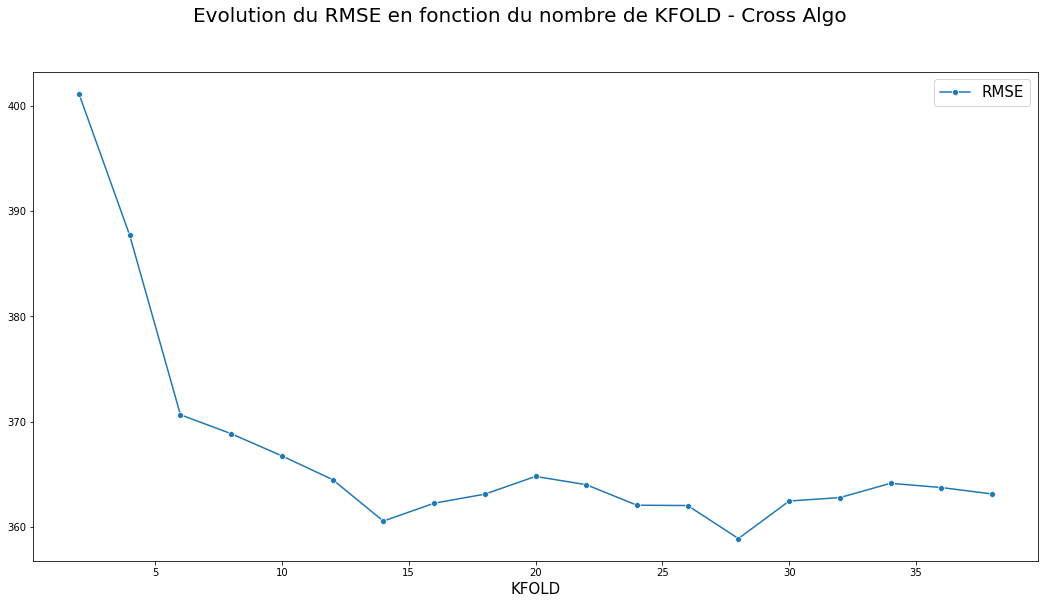

In [26]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Evolution du RMSE en fonction du nombre de KFOLD - Cross Algo", fontsize=20)

sns.lineplot(
    x = cv_list, 
    y=RMSE_list,
    label="RMSE",
    linestyle="-",
    marker = "o"
    
)

ax.set_xlabel("KFOLD", fontsize=15)
ax.set_ylabel("", fontsize=15)
ax.legend(fontsize=15)

## Lasso regression - Alpha Study

### Best alpha

In [27]:
def lasso_alpha_test(alphaList):
    
    lasso = Lasso(max_iter=10000)
    param_grid = [{'alpha': alphaList}]

    grid_search_lasso = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search_lasso.fit(X_train, y_train)

    grid_results_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
    
    print("--------------- LASSO ALPHA STUDY -------------------")
    print("*****************************************************")
    print("")
    print(f"The Best Alpha is --> {grid_search_lasso.best_estimator_}")
    print("-----------------------------------------------------")
    
    return grid_results_lasso, grid_search_lasso.best_estimator_

In [28]:
grid_results_lasso, bestAlpha = lasso_alpha_test([10,1000,100])

--------------- LASSO ALPHA STUDY -------------------
*****************************************************

The Best Alpha is --> Lasso(alpha=100, max_iter=10000)
-----------------------------------------------------


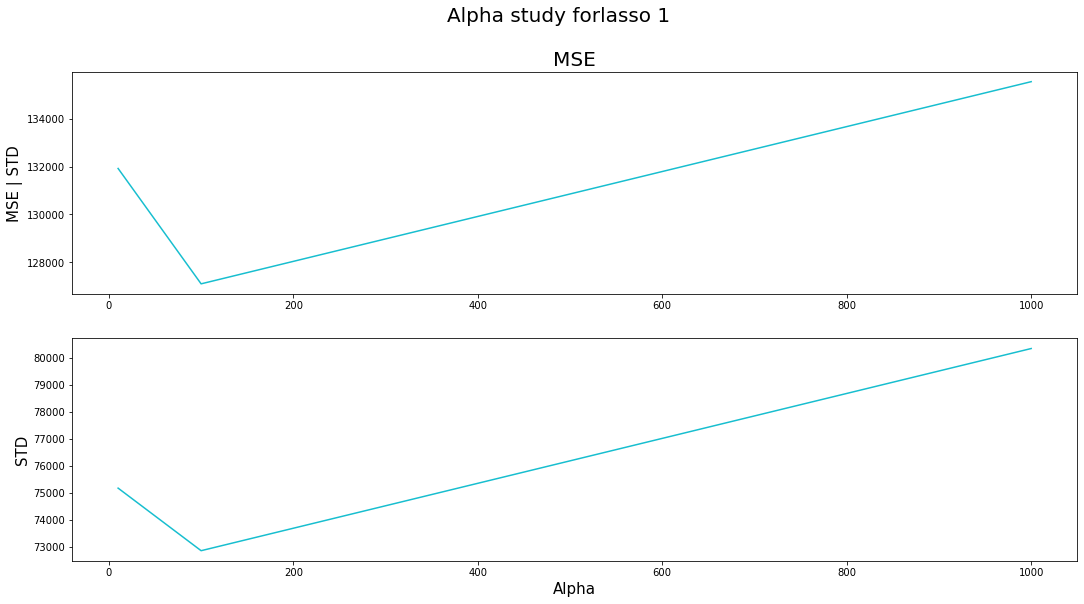

In [29]:
plot_result_alpha(grid_results_lasso, "lasso 1")

--------------- LASSO ALPHA STUDY -------------------
*****************************************************

The Best Alpha is --> Lasso(alpha=150, max_iter=10000)
-----------------------------------------------------


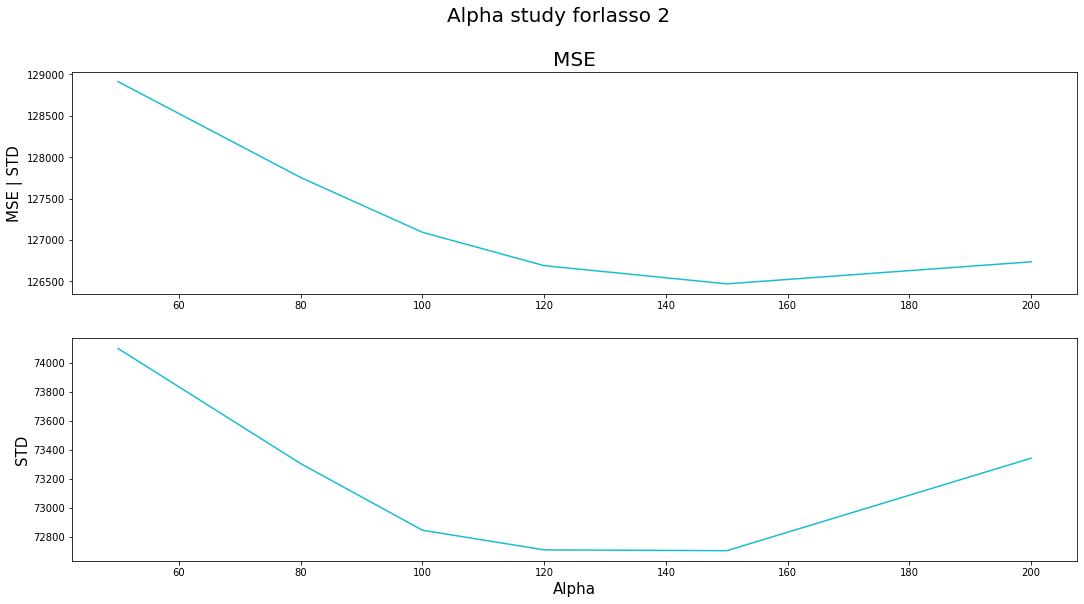

In [30]:
results, bestAlpha = lasso_alpha_test([50, 80, 100, 120, 150, 200])
plot_result_alpha(results, "lasso 2")

--------------- LASSO ALPHA STUDY -------------------
*****************************************************

The Best Alpha is --> Lasso(alpha=150, max_iter=10000)
-----------------------------------------------------


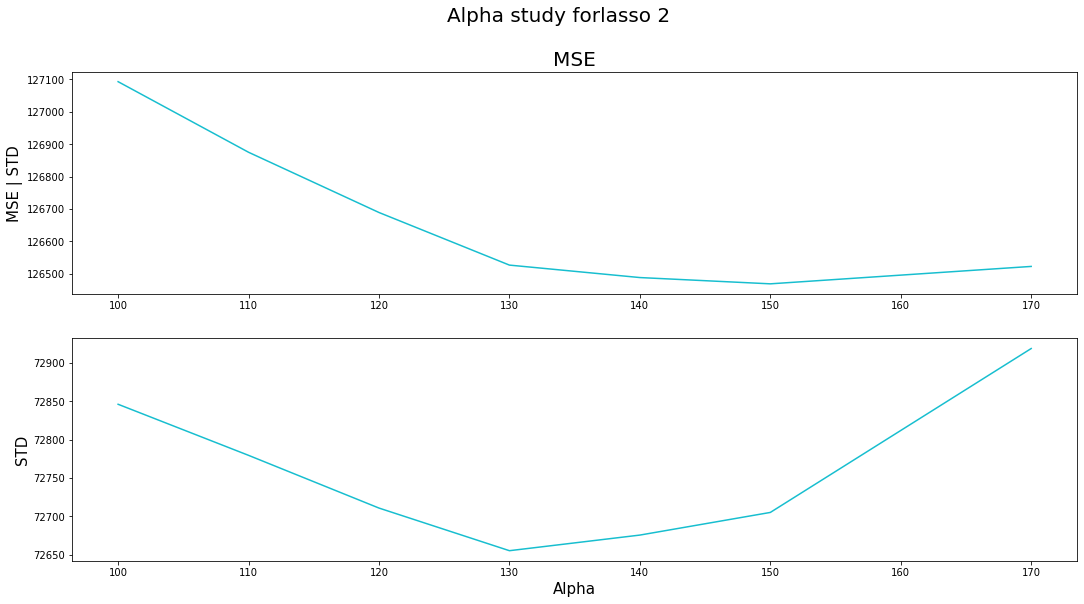

In [31]:
results, besalpha = lasso_alpha_test([100, 110, 120, 130, 140, 150, 170])
plot_result_alpha(results, "lasso 2")

## Fitting the Lasso modèle 

### Alpha = 150 (optimal)

In [32]:
lasso_130 = Lasso(alpha=130)

In [33]:
lasso_130.fit(X_train, y_train)

# predict y values for testing data set
y_pred_train = lasso_130.predict(X_train)
y_pred_test = lasso_130.predict(X_test)

print("------------------------------------------------------")
print("-------------------- LASSO_130 MODEL --------------------")
print("------------------------------------------------------")
print("")
MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y_test, y_pred_test)

compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

------------------------------------------------------
-------------------- LASSO_130 MODEL --------------------
------------------------------------------------------

MSE ----> 84814.99382814649
RMSE ---> 291.23013894194827
MAE ----> 230.76501763892554
MEDAE --> 194.37442219705633
R2 -----> 0.4981584501008205
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Results for TRAIN data :

MSE ----> 101966.07188936183
RMSE ---> 319.3212675180935
MAE ----> 214.5506559911774
MEDAE --> 144.59392711148848
R2 -----> 0.5209728910067712
----------------------------------------------
Results for TEST data 

MSE ----> 84814.99382814649
RMSE ---> 291.23013894194827
MAE ----> 230.76501763892554
MEDAE --> 194.37442219705633
R2 -----> 0.4981584501008205
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


In [35]:
features = df_hitters.columns
beta_i = lasso_130.coef_

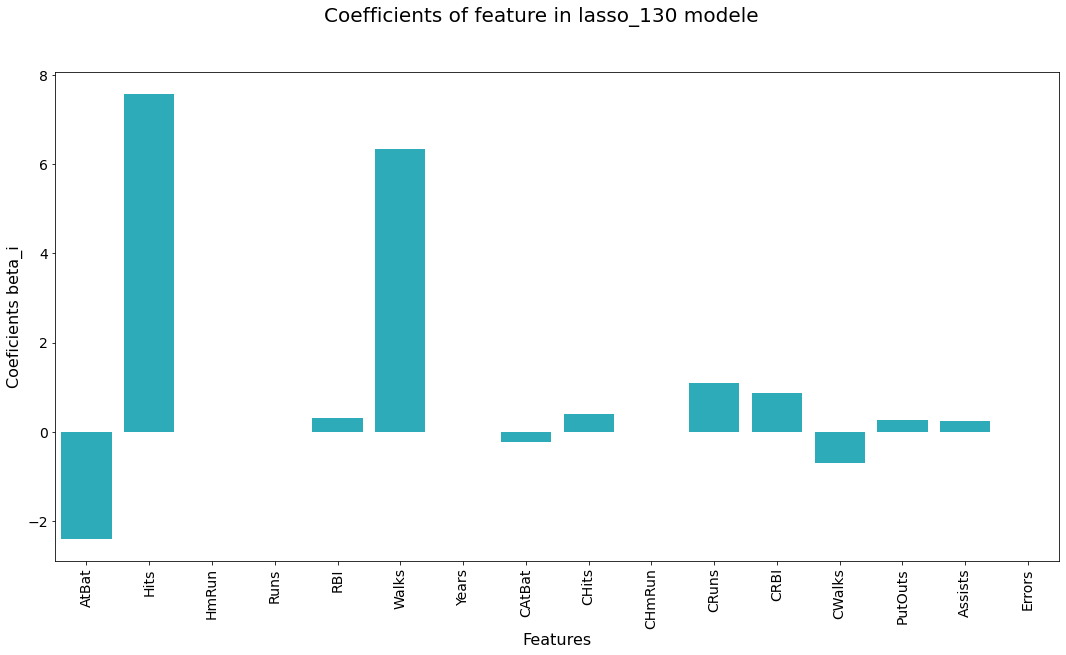

In [37]:
fig, ax = plt.subplots(figsize=(18, 9))
fig.suptitle("Coefficients of feature in lasso_130 modele", fontsize=20)

# create the bar plot using Seaborn
sns.barplot(x=features, y=beta_i, ax=ax, color=colors[0])

# customize the plot
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Coeficients beta_i', fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xticklabels(features, rotation=90, fontsize=14)

# show the plot
plt.show()

------

In [38]:
#lasso_800 = Lasso(alpha=800)
#lasso_800.fit(X_train, y_train)
#
## predict y values for testing data set
#y_pred_train = lasso_800.predict(X_train)
#y_pred_test = lasso_800.predict(X_test)
#
#print("------------------------------------------------------")
#print("-------------------- LASSO_150 MODEL --------------------")
#print("------------------------------------------------------")
#print("")
#MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y_test, y_pred_test)
#compare_train_test(y_train, y_pred_train, y_test, y_pred_test)
#features = df_hitters.columns
#beta_i = lasso_800.coef_
#fig, ax = plt.subplots(figsize=(18, 9))
#fig.suptitle("Coefficients of feature in lasso_800 modele", fontsize=20)
#
## create the bar plot using Seaborn
#sns.barplot(x=features, y=beta_i, ax=ax, color=colors[0])
#
## customize the plot
#ax.set_xlabel('Features', fontsize=16)
#ax.set_ylabel('Coeficients beta_i', fontsize=16)
#ax.tick_params(labelsize=14)
#ax.set_xticklabels(features, rotation=90, fontsize=14)
#
## show the plot
#plt.show()

### Visualisation des prédictions

<AxesSubplot:xlabel='Salary'>

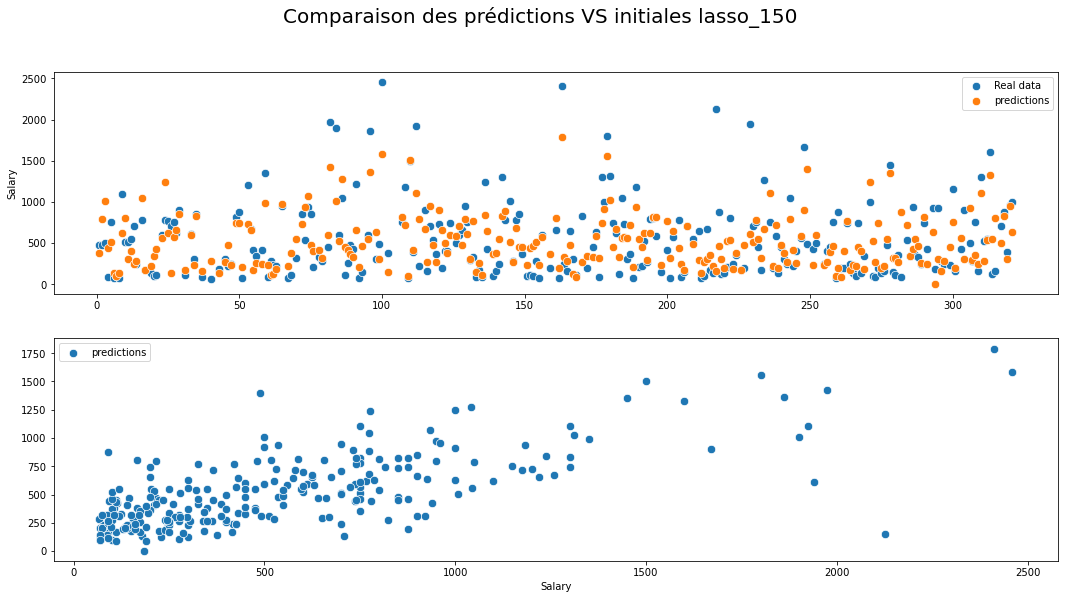

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(18,9))
fig.suptitle("Comparaison des prédictions VS initiales lasso_150", fontsize=20)

#compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

predictions = lasso_130.predict(df_hitters)

sns.scatterplot(
    ax=ax[0],
    data=df_hitters.index, 
    x=df_hitters.index, 
    #x="MSE",
    y=salary, 
    s=70,
    label="Real data"
)
sns.scatterplot(
    ax=ax[0],
    data=df_hitters, 
    x=df_hitters.index, 
    y=predictions, 
    s=70,
    label="predictions"
)

sns.scatterplot(
    ax=ax[1],
    data=df_hitters, 
    x=salary, 
    #x="MSE",
    y=predictions, 
    s=70,
    label="predictions"
)

# Ridge Study

In [40]:
def ridge_alpha_test(alphaList):
    ridge = Ridge(max_iter=10000)

    param_grid = [{'alpha': alphaList}]

    grid_search_ridge = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search_ridge.fit(X_train, y_train)

    grid_results_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
    
    print("--------------- RIDGE ALPHA STUDY -------------------")
    print("*****************************************************")
    print("")
    print(f"The Best Alpha is --> {grid_search_ridge.best_estimator_}")
    print("-----------------------------------------------------")
    
    return grid_results_ridge, grid_search_ridge.best_estimator_

In [41]:
def ridge_alpha_test_std(alphaList):
    ridge = Ridge(max_iter=10000)

    param_grid = [{'alpha': alphaList}]

    grid_search_ridge = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search_ridge.fit(X_train__std, y_train)

    grid_results_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
    
    print("--------------- RIDGE ALPHA STUDY STD ----------------")
    print("*****************************************************")
    print("")
    print(f"The Best Alpha is --> {grid_search_ridge.best_estimator_}")
    print("-----------------------------------------------------")
    
    return grid_results_ridge, grid_search_ridge.best_estimator_

----

## Non standardisé

In [42]:
ridge = Ridge()

In [43]:
cv_scores = cross_val_score(ridge, X_train, y_train, cv = 10, scoring='neg_mean_squared_error') 
MSE = -cv_scores
RMSE = np.sqrt(MSE)
print("------------------------------------------------------")
print("----------- LINEAR MODEL KFOLD Dispersion ------------")
print("------------------------------------------------------")
print("")
print(f"RMSE --------------------------> {RMSE.mean()}")
print(f"STD des RMSE selon interval ---> {RMSE.std()}")

------------------------------------------------------
----------- LINEAR MODEL KFOLD Dispersion ------------
------------------------------------------------------

RMSE --------------------------> 348.9101943907863
STD des RMSE selon interval ---> 108.24633210197099


--------------- RIDGE ALPHA STUDY -------------------
*****************************************************

The Best Alpha is --> Ridge(alpha=200, max_iter=10000)
-----------------------------------------------------


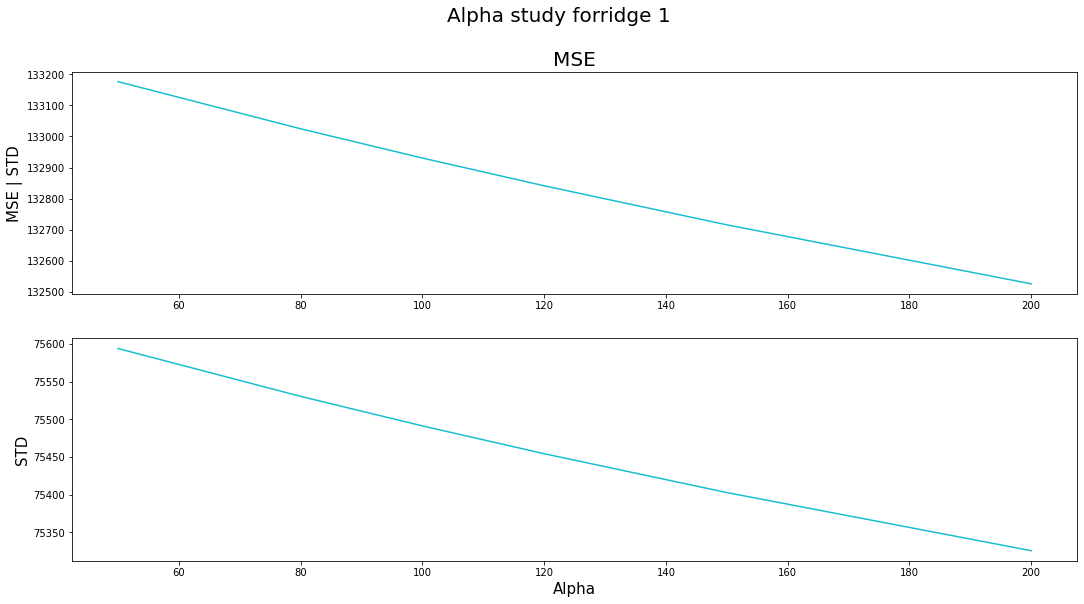

In [44]:
results, bestAlpha = ridge_alpha_test([50, 80, 100, 120, 150, 200])
plot_result_alpha(results, "ridge 1")

## Standardisé

### Standardization des features

In [45]:
# Pour standardiser les données "train" (fit & transform)

#standardize data
scaler = StandardScaler()
X_train__std = pd.DataFrame(scaler.fit_transform(X_train))
X_train__std = X_train__std.rename(columns={0: 'AtBat', 1: 'Hits', 2: 'HmRun', 3: 'Runs', 4: 'RBI', 5: 'Walks', \
                                    6: 'Years', 7: 'CAtBat', 8: 'CHits', 9: 'CHmRun', 10: 'CRuns', 11: 'CRBI',\
                                    12: 'CWalks', 13: 'PutOuts', 14: 'Assists', 15: 'Errors'})
X_train__std

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,1.275440,1.312961,-0.854454,0.788908,-0.048312,-0.281503,0.729978,0.732007,0.607356,-0.587615,0.408463,0.001580,-0.241711,-0.019082,2.079928,2.413697
1,-0.987271,-0.918116,-0.744003,-0.938371,-0.988780,-0.419111,1.326683,0.524013,0.379686,-0.428291,0.457565,-0.033651,0.433759,-0.708034,0.305685,0.755858
2,-1.752699,-1.502962,-0.744003,-1.460572,-0.838305,-1.198890,0.332175,-0.842143,-0.844405,-0.621756,-0.807542,-0.700109,-0.719571,-0.527846,-0.744946,-1.203406
3,-1.235700,-0.918116,-0.744003,-1.380233,-0.913543,-1.290628,-0.861233,-0.987905,-0.949370,-0.746939,-0.960625,-0.893881,-0.884845,-0.022615,-0.703199,-0.901981
4,0.691298,0.294897,1.906823,0.949586,1.230724,2.287181,2.122288,2.132411,1.810750,3.145114,2.355224,2.397304,4.019502,1.839320,-0.097869,-1.052693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,-1.672128,-1.459640,0.029155,-1.340064,-0.875924,-0.877804,1.724486,1.150081,0.910422,1.255989,1.116113,1.378534,2.205073,-0.432453,-0.786693,-1.203406
193,-1.416985,-1.329674,-0.191748,-1.340064,-0.875924,-0.786066,-0.264529,-0.634567,-0.689176,-0.325869,-0.666011,-0.576800,-0.557889,0.040980,-0.758861,-0.600555
194,-1.296128,-1.416318,-0.191748,-1.139217,-0.650212,-0.098025,-0.861233,-0.901033,-0.896148,-0.644516,-0.868197,-0.823418,-0.658491,0.620406,-0.626663,-0.148417
195,0.463012,0.988047,-0.633552,0.266708,-0.161169,-0.556719,-0.264529,-0.287912,-0.230881,-0.473812,-0.316519,-0.245039,-0.299198,1.973577,-0.264856,0.002295


In [46]:
cv_scores = cross_val_score(ridge, X_train__std, y_train, cv = 10, scoring='neg_mean_squared_error') 
MSE = -cv_scores
RMSE = np.sqrt(MSE)
print("------------------------------------------------------")
print("----------- LINEAR MODEL KFOLD Dispersion ------------")
print("------------------------------------------------------")
print("")
print(f"RMSE --------------------------> {RMSE.mean()}")
print(f"STD des RMSE selon interval ---> {RMSE.std()}")

------------------------------------------------------
----------- LINEAR MODEL KFOLD Dispersion ------------
------------------------------------------------------

RMSE --------------------------> 344.5465108698856
STD des RMSE selon interval ---> 106.33041611582955


--------------- RIDGE ALPHA STUDY STD ----------------
*****************************************************

The Best Alpha is --> Ridge(alpha=1.3, max_iter=10000)
-----------------------------------------------------


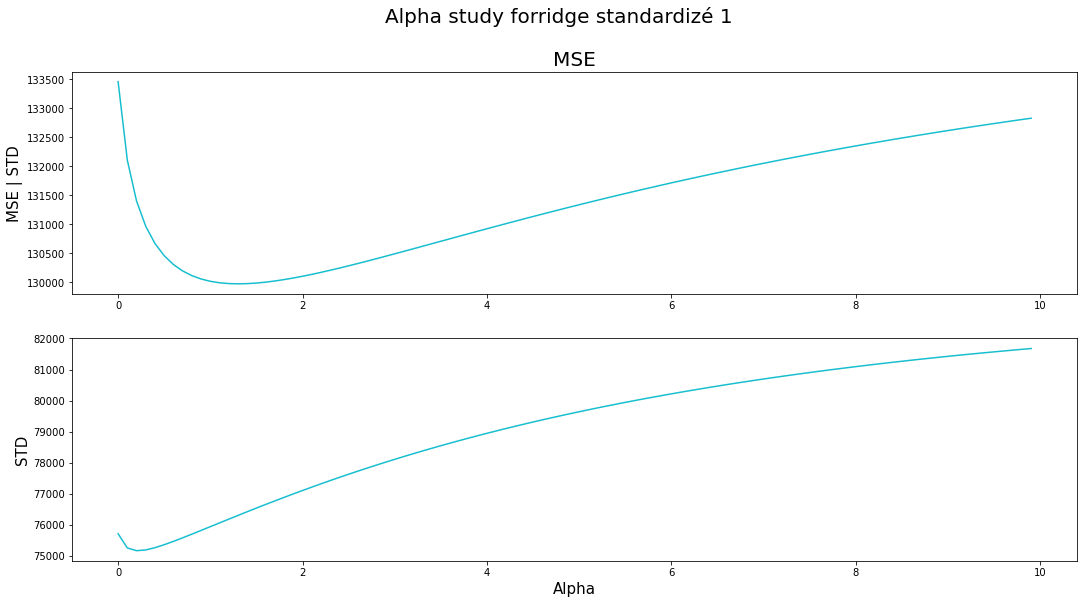

In [47]:
results, bestAlpha = ridge_alpha_test_std(np.arange(0, 10, 0.1))
plot_result_alpha(results, "ridge standardizé 1")

### Ridge avec Alpha = 1.3 (optimal)

In [67]:
df_hitters__std = pd.DataFrame(scaler.transform(df_hitters))
df_hitters__std = df_hitters__std.rename(columns={0: 'AtBat', 1: 'Hits', 2: 'HmRun', 3: 'Runs', 4: 'RBI', 5: 'Walks', \
                                    6: 'Years', 7: 'CAtBat', 8: 'CHits', 9: 'CHmRun', 10: 'CRuns', 11: 'CRBI',\
                                    12: 'CWalks', 13: 'PutOuts', 14: 'Assists', 15: 'Errors'})

In [59]:
X_test__std = pd.DataFrame(scaler.transform(X_test))
X_test__std = X_test__std.rename(columns={0: 'AtBat', 1: 'Hits', 2: 'HmRun', 3: 'Runs', 4: 'RBI', 5: 'Walks', \
                                    6: 'Years', 7: 'CAtBat', 8: 'CHits', 9: 'CHmRun', 10: 'CRuns', 11: 'CRBI',\
                                    12: 'CWalks', 13: 'PutOuts', 14: 'Assists', 15: 'Errors'})

X_test__std.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,1.369440,1.118013,1.796372,3.038388,0.816918,2.195442,0.133274,0.591256,0.679796,0.368328,1.451164,0.239391,1.605054,0.489682,-0.821482,-0.449843
1,0.019870,-0.333271,-0.412650,-0.295662,-0.838305,-0.510850,-1.060135,-0.704316,-0.727614,-0.644516,-0.689118,-0.782315,-0.694420,-0.407722,1.356315,2.413697
2,-1.155128,-1.156387,-0.302199,-0.817863,-1.101637,0.177191,0.928880,0.730754,0.725625,1.403932,0.989025,1.084940,1.306841,1.185700,-0.605789,-0.901981
3,0.026584,-0.311610,-0.854454,-0.496509,-0.612593,1.140447,0.332175,0.383263,0.212630,-0.132404,0.200500,0.086722,0.534361,-0.019082,2.539144,1.509421
4,-0.530701,-0.701507,0.470959,-0.858032,-0.010694,-0.189764,-0.463430,-0.480034,-0.548731,0.004159,-0.475379,-0.341925,-0.169853,1.549607,-0.243983,-0.901981


In [56]:
ridge_1_3 = Ridge(alpha=1.3)

In [57]:
ridge_1_3.fit(X_train__std, y_train)

# predict y values for testing data set
y_pred_train = ridge_1_3.predict(X_train__std)
y_pred_test = ridge_1_3.predict(X_test__std)

print("------------------------------------------------------")
print("-------------------- LASSO_130 MODEL --------------------")
print("------------------------------------------------------")
print("")
MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y_test, y_pred_test)

compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

------------------------------------------------------
-------------------- LASSO_130 MODEL --------------------
------------------------------------------------------

MSE ----> 91672.28778247307
RMSE ---> 302.77431823467634
MAE ----> 237.21749900665037
MEDAE --> 173.2467988397955
R2 -----> 0.457584550713098
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Results for TRAIN data :

MSE ----> 101739.49390589738
RMSE ---> 318.96628960737746
MAE ----> 214.22161126899064
MEDAE --> 150.7953467951259
R2 -----> 0.5220373332704514
----------------------------------------------
Results for TEST data 

MSE ----> 91672.28778247307
RMSE ---> 302.77431823467634
MAE ----> 237.21749900665037
MEDAE --> 173.2467988397955
R2 -----> 0.457584550713098
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


### Visualisation des prédictions

Text(0.5, 1.0, 'all df_hitters dataframe')

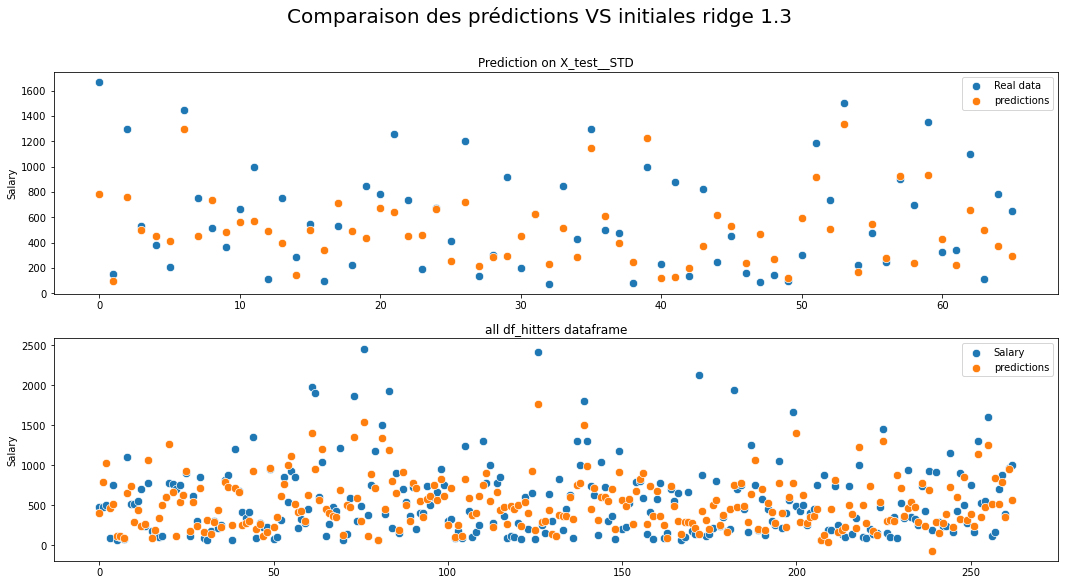

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(18,9))
fig.suptitle("Comparaison des prédictions VS initiales ridge 1.3", fontsize=20)

#compare_train_test(y_train, y_pred_train, y_test, y_pred_test)

predictions = ridge_1_3.predict(X_test__std)

sns.scatterplot(
    ax=ax[0],
    x=X_test__std.index, 
    #x="MSE",
    y=y_test, 
    s=70,
    label="Real data"
)
sns.scatterplot(
    ax=ax[0],
    x=X_test__std.index, 
    y=predictions, 
    s=70,
    label="predictions"
)

predictionsOverall = ridge_1_3.predict(df_hitters__std)

sns.scatterplot(
    ax=ax[1],
    x=df_hitters__std.index, 
    y=salary, 
    s=70,
    label="Salary"
)
sns.scatterplot(
    ax=ax[1],
    x=df_hitters__std.index, 
    y=predictionsOverall, 
    s=70,
    label="predictions"
)

ax[0].set_title("Prediction on X_test__STD")
ax[1].set_title("all df_hitters dataframe")

In [72]:
features = df_hitters.columns
beta_i = ridge_1_3.coef_

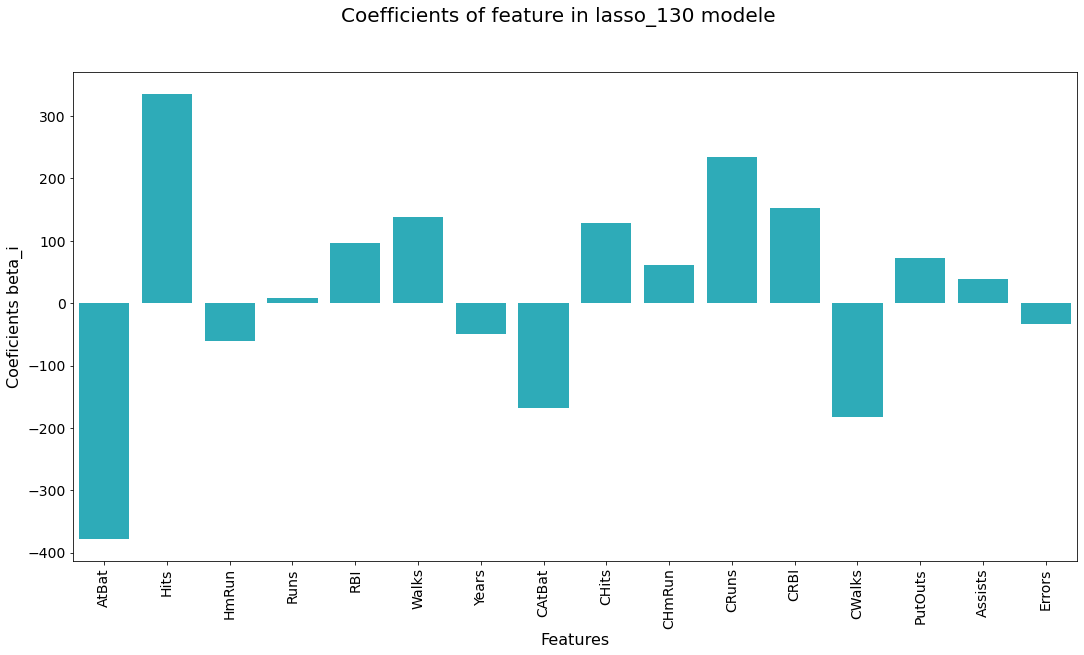

In [73]:
fig, ax = plt.subplots(figsize=(18, 9))
fig.suptitle("Coefficients of feature in lasso_130 modele", fontsize=20)

# create the bar plot using Seaborn
sns.barplot(x=features, y=beta_i, ax=ax, color=colors[0])

# customize the plot
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Coeficients beta_i', fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xticklabels(features, rotation=90, fontsize=14)

# show the plot
plt.show()